# 估计进阶

In [33]:
import matplotlib.pyplot as plt

import code.thinkbayes as thinkbayes

%matplotlib inline

## 把上一章做的Suite拿过来

In [2]:
from code.thinkbayes import Pmf
from abc import ABCMeta, abstractmethod
class Suite(Pmf): # 抽象类
    
    __metaclass__ = ABCMeta
    
    def __init__(self, hypos):
        '''
        构造函数
        
        Args:
            hypos -- 全部假设
        '''
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    
    @abstractmethod  ##抽象方法
    def Likelihood(self, data, hypo):
        '''
        根据传入data求似然度
        
        Args:
            data -- 传入的信息
            hypo -- 某一种假设
            
        Returns:
            like -- 更新后的概率
        '''
        
    def Update(self, data):
        '''
        修正相应假设的概率，这个方法是叠加的
        
        Args:
            data -- 用于修正响应假设概率的信息
        '''
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
        
    def PrintPredict(self):
        '''
        打印各个假设及其对应的概率
        '''
        for hypo, prob in self.Items():
            print str(hypo) + ':' + str(prob)

## 欧元问题

投掷一枚硬币250次，其中有140次正面，110次反面，这个结果是否对“硬币偏心且不均匀”提供了支持？

In [43]:
class Euro(Suite):
    def Likelihood(self, data, hypo):
        if data == 'H':
            return hypo / 100.
        else:
            return 1- hypo / 100.
        
    def MaxLikelihood(self):
        # 遍历假设-like映射数组，比较的是like，返回的是假设
        return max([(item[1], item[0]) for item in self.Items()])[1]
        
    def Draw(self):
        X = []
        y = []
        for item in self.Items():
            X.append(item[0])
            y.append(item[1])
        plt.plot(X, y)

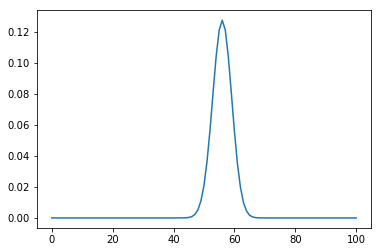

In [44]:
euro = Euro(range(0,101))
datas = 'H'*140 + 'T'*110
for data in datas:
    euro.Update(data)

euro.Draw()

### 平均值

In [45]:
euro.Mean()

55.952380952380956

### 最大值

In [42]:
euro.MaxLikelihood()

56

### 置信区间

In [46]:
thinkbayes.CredibleInterval(euro, 90)

(51, 61)

### 50的概率

In [47]:
euro.Prob(50)

0.02097652612954468

### 小结

首先概率为50的假设不在90的置信区间内，且50的假设对应的概率仅为0.02，目前数据起码能证明硬币有问题；

## 先验概率的湮没

上述问题中，我们的先验概率分布是均等的，这个似乎有问题，因为即便硬币有问题，那么得到的x虽然会偏离50%，但是应该也不会到10%或者90%，也就是说对于各个假设来说，他们的先验概率应该不是一样的，而是成三角形的，如下：

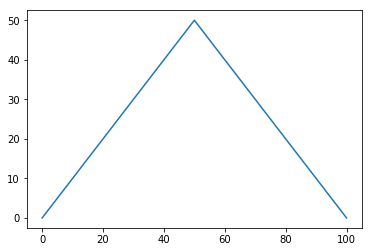

In [48]:
X = range(0,101)
y = [x if x<=50 else 100-x for x in X]
plt.plot(X, y)

### 优化欧元问题的先验概率

In [49]:
class SuperEuro(Euro):
    def __init__(self, hypos):
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo if hypo <= 50 else 100-hypo)
        self.Normalize()

### 优化后的分布图

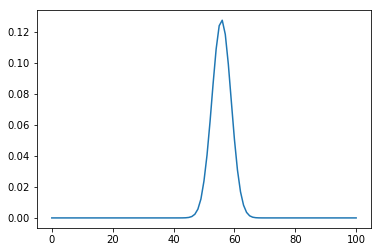

In [50]:
euro = SuperEuro(range(0,101))
datas = 'H'*140 + 'T'*110
for data in datas:
    euro.Update(data)

euro.Draw()

### 优化后的平均值

In [52]:
euro.Mean()

55.74349943859506

### 优化后的最大值

In [53]:
euro.MaxLikelihood()

56

### 优化后的置信区间

In [54]:
thinkbayes.CredibleInterval(euro, 90)

(51, 61)

### 先验湮没小结

能够看到，虽然先验概率差别很大，但是由于后期数据量充足，导致后验概率收敛，因此此处的先验概率对后验概率影响很小其实；

## 讨论

1. 客观性：即使两人有着不同的先验信仰，随着数据的增多，后验分布也会收敛，而分布之间的差异可以小到忽略不计；
2. 基于模型决策：但是首先贝叶斯是基于模型决策的，如果使用不同的模型，那么就无法得到相同的似然度，后验概率也就不可能收敛；
3. 克伦威尔法则：所有假设，即便你认为可能性为0的假设也不要设置为0，否则再多的数据也无法撼动它为0的概率；

## 练习

### 练习-1

假设不是直接观察抛掷硬币，而是使用一个不总是正确的工具来测量结果，具体的说，假设有一个概率为y将实际为正，但是报告为反，编写一个类来估计这样一系列给定了结果的硬币的偏置量和值y，后验分布的范围是怎样依赖于y的？

### 练习-2

设计一个系统，当redditor投票后，根据redditor的可信度估计并且更新链接2的质量，而该redditor的可信度估计会依据这一链接的质量被更新。一种方法是将链接的质量以赢得upvote的概率建模，redditor的可信度以对高品质条目给出正确的upvote的概率建模，编写一个类来定义redditor和链接，只要redditor投了票，update函数对这两个对象进行更新；